In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import sklearn as skl
from datetime import datetime
import seaborn as sns
from math import log
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import os
import time as time
from datetime import datetime

In [11]:
# load the data
data = pd.read_csv(r'C:\Users\ASUS Laptop\Downloads\vibonsdatacomplete.csv', parse_dates = True, low_memory = False)

In [12]:
# take a quick look at the data
data.head()

,[2020-10-08 15:26:29] production_jobs.INFO: Customer Id,User Id,User Created At,Activation Date,Activity Date,Name,Content Type,Journey Name,Action,Duration,Device,Channel,Session Id,Rating
0,[2020-10-08 15:26:29] production_jobs.INFO: 8,147,2018-09-26 12:19:32,2018-09-25 21:05:24,2018-09-27 09:30:53,Welcome to Journey,INTERNAL_VIDEO,Welcome,0,NaN,Web,Direct Connection,eDE0NzY2Mg==,-
1,[2020-10-08 15:26:29] production_jobs.INFO: 9,139,2018-09-21 17:14:07,2018-09-22 10:00:02,2018-10-01 11:18:20,İnovasyoncunun Beş Alışkanlığı,INFOGRAPHIC,İnovatif Bakış Açısı,100,NaN,Web,Direct Connection,eDEzOTY1MQ==,-
2,[2020-10-08 15:26:29] production_jobs.INFO: 9,139,2018-09-21 17:14:07,2018-09-23 10:00:59,2018-10-01 11:19:18,Peter Drucker’a göre İnovasyona Fırsat Sağlaya...,INTERNAL_ARTICLE,İnovatif Bakış Açısı,100,NaN,Web,Direct Connection,eDEzOTY1Mg==,-
3,[2020-10-08 15:26:29] production_jobs.INFO: 10,200,2018-10-03 09:36:25,2018-10-01 08:00:36,2018-10-03 09:48:55,Welcome to Journey,INTERNAL_VIDEO,İnovatif Bakış Açısı,0,NaN,Web,Direct Connection,eDIwMDY4Ng==,-
4,[2020-10-08 15:26:29] production_jobs.INFO: 10,200,2018-10-03 09:36:25,2018-10-01 09:00:52,2018-10-03 10:38:28,Yenilikçinin İkilemi,INTERNAL_VIDEO,İnovatif Bakış Açısı,0,NaN,Web,Direct Connection,eDIwMDY4Nw==,-


In [13]:
# eliminate a couple corrupted rows
data = data.drop(data[data['User Id']=='User Id'].index)
data = data.drop(data[data['User Id'] == "FLIPBOOK"].index)
# drop nan rows in the action column, there are only 9 of these in the whole dataset
data.dropna(subset = ['Action'], inplace = True)

# rename customer id and rating column
data.rename(columns={"[2020-10-08 15:26:29] production_jobs.INFO: Customer Id" : "Customer Id", "Rating  ": "Rating"}, inplace = True)

# extract just the customer id in the customer id column
customerids = data["Customer Id"]
clean_ids = []
for i, id in enumerate(customerids):
    split_id = id.split()
    clean_ids.append(int(split_id[-1]))
data["Customer Id"] = clean_ids

# set the datatype for the columns
data = data.astype({'Customer Id': 'int', 'User Id': 'int', 'Activation Date': 'datetime64', 'Activity Date': 'datetime64', 'Action': 'int'})

In [14]:
# add the day of week for Activation and Activity
daysofweek = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ActivationDay = []
ActivityDay = []
for entry, entry1 in zip(data["Activation Date"], data["Activity Date"]):
    
    ActivationDay.append(entry.day_name())
    ActivityDay.append(entry1.day_name())

data['Activation Day'] = ActivationDay
data['Activity Day'] = ActivityDay

In [15]:
# extract just the time of the Activity Date column, add to a new column
times = data['Activity Date']
list_of_times = []
for time in times:
    time_of_day = time.strftime("%X")
    list_of_times.append(time_of_day)

data['Time'] = list_of_times
data['Activity Time'] = list_of_times
data = data.astype({'Activity Time': 'datetime64'})

In [16]:
# calculate the number of hours elapsed between the Activation Date and Activity Date, add it as a column to the data
activitydelay = []
for activation, activity in zip(data['Activation Date'] , data['Activity Date']):
    lag = activation - activity
    hoursfullday = -lag.days*24
    seconds = lag.seconds
    hourspartday = seconds / 3600
    hourstotal = round((hoursfullday - hourspartday), 2)
    zero = 0
    negative = 0
    
    activitydelay.append(hourstotal)
    
data['Activity Delay'] = activitydelay

In [17]:
# this is a function which eliminates the repeated rows for a user
# there are some pieces of content which a user has opened many time (up to 20 or 30)
# this only considers the first time a user opened a piece of content that he/she received
def eliminate_repeats(user):
    
    names = user['Name'].unique()

    user_no_repeats = pd.DataFrame(columns = user.columns)

    for i, name in enumerate(names):
        latest_content = user.loc[user['Name'] == name, 'Activity Date'].max()
        name_repeat = user[user['Name'] == name]
        sent_dates = name_repeat['Activation Date'].unique()

        for i, date in enumerate(sent_dates):
            date_repeat = name_repeat[name_repeat['Activation Date'] == date]
            earliest_content = date_repeat.loc[date_repeat['Activation Date'] == date, 'Activity Date'].min()

            row = date_repeat[(date_repeat['Activation Date'] == date) & (date_repeat['Activity Date'] == earliest_content)]
            row = row.sort_values(by = ['Action'])
            user_no_repeats = user_no_repeats.append(row.iloc[0], ignore_index = True)

    return user_no_repeats

In [18]:
# this is a function to sort a dataframe for a user by the day of the week and by time of the day
def sort(user):
    days = user['Activity Day']
    temp = []
    for day in days:
        if day == 'Monday':
            temp.append(0)
        elif day == 'Tuesday':
            temp.append(1)
        elif day == 'Wednesday':
            temp.append(2)
        elif day == 'Thursday':
            temp.append(3)
        elif day == 'Friday':
            temp.append(4)
        elif day == 'Saturday':
            temp.append(5)
        elif day == 'Sunday':
            temp.append(6)
    user['Temp'] = temp
    
    user.sort_values(by = ['Temp', 'Time'], ignore_index = True, inplace = True)
    user.drop(columns = ['Temp'], inplace = True)
    
    return user

In [19]:
# prepare the user information to generate the recommendations
def process_user(user):
    
    # eliminate the repeats for the user according to the function defined above
    user = eliminate_repeats(user)

    # drop the columns that we aren't going to use for the analysis
    cols_to_drop = ['User Created At', 'Activation Date', 'Activity Date', 'Duration', 'Session Id', 'Rating']
    user.drop(columns = cols_to_drop, inplace = True)

    # then reorder the columns we are keeping
    user = user[['Customer Id', 'User Id', 'Activity Day', 'Time', 'Name', 'Content Type', 'Journey Name', 'Action', 'Device', 'Channel', 'Activity Delay']]

    # sort the data for the user according to the sort function defined above
    user = sort(user)
    
    return user

In [20]:
def generate_user_recommendations(user):
    # get the entries for the with completion above 85%
    # if there are none, look for entries above 50%
    # else look at remaining entries
    if len(user[user['Action'] >= 85]) > 0:
        recommendation = user[user['Action'] >= 85]
    elif len(user[user['Action'] >= 50]) > 0:
        recommendation = user[user['Action'] >= 50]
    else:
        recommendation = user[user['Action'] >= 0]
    
    return recommendation

In [21]:
def graph_user(user):
    # create tick marks for x axis
    xinterval1 = [pd.Timestamp('0:00:00'), pd.Timestamp('1:00:00'), pd.Timestamp('2:00:00'), pd.Timestamp('3:00:00'), pd.Timestamp('4:00:00'), pd.Timestamp('5:00:00'), 
                  pd.Timestamp('6:00:00'), pd.Timestamp('7:00:00'), pd.Timestamp('8:00:00'), pd.Timestamp('9:00:00'), pd.Timestamp('10:00:00'), pd.Timestamp('11:00:00'), 
                 pd.Timestamp('12:00:00'), pd.Timestamp('13:00:00'), pd.Timestamp('14:00:00'), pd.Timestamp('15:00:00'), pd.Timestamp('16:00:00'), pd.Timestamp('17:00:00'),
                 pd.Timestamp('18:00:00'), pd.Timestamp('19:00:00'), pd.Timestamp('20:00:00'), pd.Timestamp('21:00:00'), pd.Timestamp('22:00:00'), pd.Timestamp('23:00:00'), pd.Timestamp('23:59:59')]

    user = user.copy()
    
    ActivityTime = []
    for activity in user['Time']:
        ActivityTime.append(activity)
    user['Activity Time'] = ActivityTime
    user = user.astype({'Activity Time': 'datetime64'})

    for day in daysofweek:
        
        currentday = user[user['Activity Day'] == day]
        currentday = currentday.copy()
        
        # format date for the graph
        now = datetime.today()
        curyear=now.strftime('%Y')
        curmonth=now.strftime('%m')
        curday=now.strftime('%d')
        for date in currentday["Activity Time"]:
            date.replace(year = int(curyear), month = int(curmonth), day = int(curday))

        ax1 = currentday.plot.scatter(x = "Activity Time", y = "Action", s = 50, figsize = (15,3), title = day, xlim = (pd.Timestamp(xinterval1[0]), pd.Timestamp(xinterval1[-1])), ylim = (-5,105), xticks = xinterval1, sharex = False)
        dateformat = md.DateFormatter('%H:%M')
        ax1.xaxis.set_major_formatter(dateformat)
        ax1.grid()

In [22]:
# generate a pie chart for Content Type, Device Type, and Connection Type
def pie_charts(user):
    item_counts1 = user["Content Type"].value_counts()
    item_counts2 = user["Device"].value_counts()
    item_counts3 = user["Channel"].value_counts()

    item_counts1_name = item_counts1.index
    item_counts1 = list(item_counts1)
    item_counts2_name = item_counts2.index
    item_counts2 = list(item_counts2)
    item_counts3_name = item_counts3.index
    item_counts3 = list(item_counts3)
    
    # show each series in pie chart
    fig1, ax1 = plt.subplots()
    ax1.pie(item_counts1, labels = item_counts1_name, autopct='%1.1f%%', radius = 1.2)
    plt.title('Content Type')
    plt.show()
    fig2, ax2 = plt.subplots()
    ax2.pie(item_counts2, labels = item_counts2_name, autopct='%1.1f%%', radius = 1.2)
    plt.title("Device Type")
    plt.show()
    fig3, ax3 = plt.subplots()
    ax3.pie(item_counts3, labels = item_counts3_name, autopct='%1.1f%%', radius = 1.2)
    plt.title("Connection Type")
    plt.show()

In [42]:
# look at data for just one user
user = data[data['User Id'] == 15000]
user_processed = process_user(user)
recommendations = generate_user_recommendations(user_processed)
recommendations.head(10)

,Customer Id,User Id,Activity Day,Time,Name,Content Type,Journey Name,Action,Device,Channel,Activity Delay
3,34,15000,Monday,15:32:21,OKRs Nedir?,INTERNAL_VIDEO,Yönlendirme ve Yönetme,100,iOS,Direct Connection,3007.32
7,34,15000,Monday,18:44:48,Canlı Yayında Hangi Konu Konuşulsun?,SURVEY,Zor Zamanlarla Başa Çıkma,100,iOS,Direct Connection,96.75
17,34,15000,Tuesday,08:45:38,Bill Gates'den İlham Verici Fikir,QUOTES,Yönlendirme ve Yönetme,100,iOS,Direct Connection,0.76
21,34,15000,Tuesday,09:11:35,Destekleyen liderlik nasıl uygulanır?,INTERNAL_ARTICLE,Yönlendirme ve Yönetme,100,iOS,Direct Connection,1.19
22,34,15000,Tuesday,09:15:22,Liderlerin Verimliliğini Artıran İletişim Takt...,INTERNAL_ARTICLE,Yönlendirme ve Yönetme,99,Web,From Email,1.26
23,34,15000,Tuesday,09:18:56,Bilişsel Yanlılıklar - Dikkat Etmeniz Gerekenler,CHECKLIST,Zor Zamanlarla Başa Çıkma,100,iOS,Direct Connection,91.32
24,34,15000,Tuesday,09:19:07,Hızlı Düşünen Beynimiz Oyun Mu Oynuyor?,EXTERNAL_VIDEO,Zor Zamanlarla Başa Çıkma,100,iOS,Direct Connection,96.99
25,34,15000,Tuesday,09:19:53,Performansı Yönetirken Etkili Koçluk Nasıl Ver...,INTERNAL_ARTICLE,Yönlendirme ve Yönetme,100,iOS,Direct Connection,3865.33
26,34,15000,Tuesday,09:19:56,Bill Gates'den İlham Verici Fikir,QUOTES,Yönlendirme ve Yönetme,100,iOS,Direct Connection,4033.33
27,34,15000,Tuesday,09:20:33,Başarılı İletişim için 3 CEO’nun “3 Kuralı”,INTERNAL_ARTICLE,İletişim,100,iOS,Direct Connection,3985.34


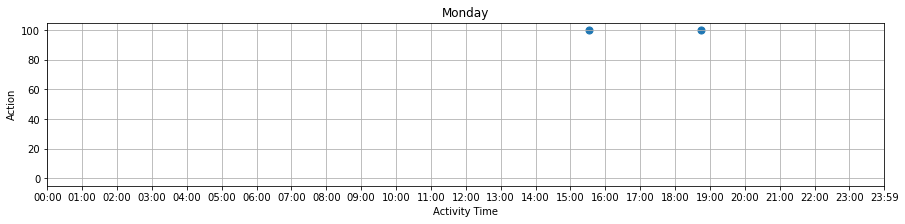

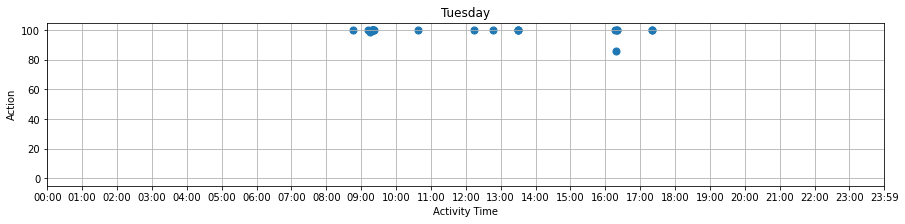

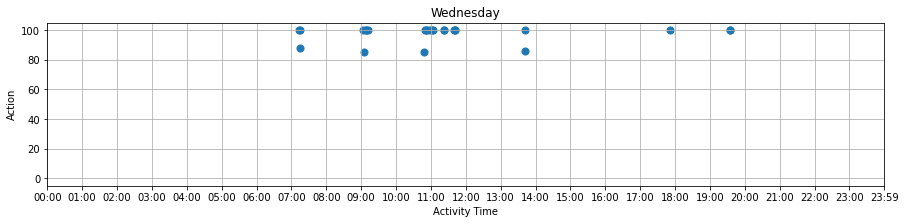

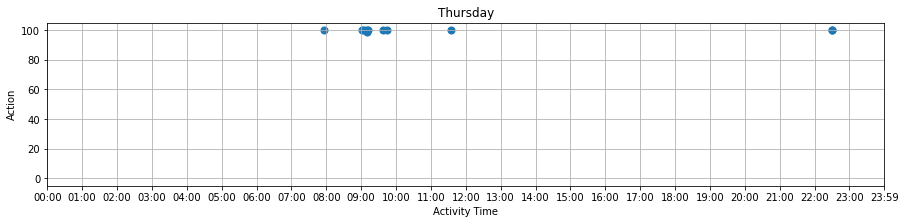

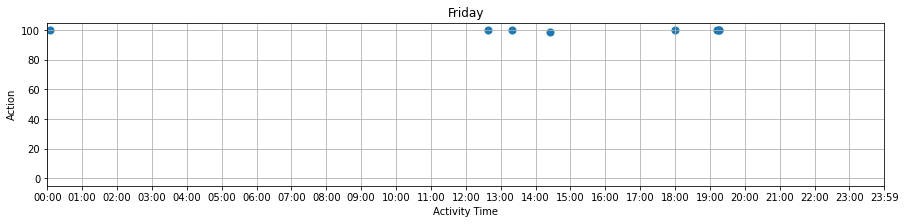

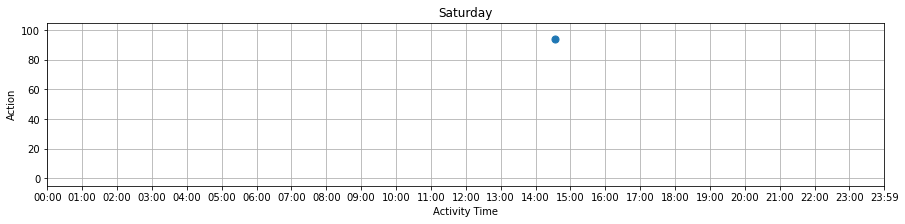

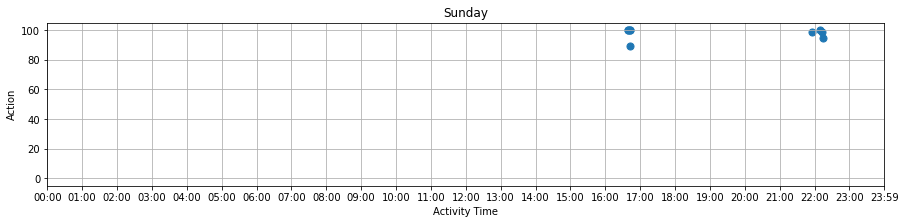

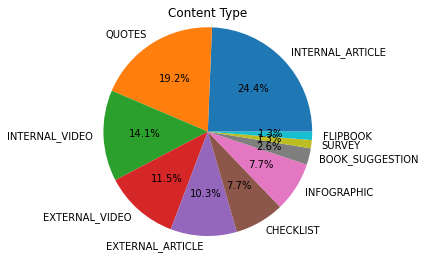

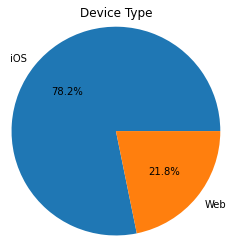

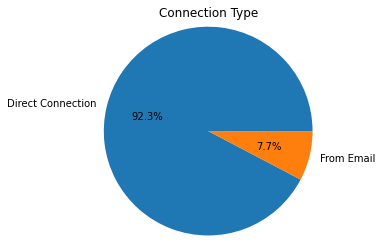

In [41]:
# show the graphs for the day of teh week
graph_user(recommendations)
pie_charts(recommendations)

In [ ]:
# generate a separate csv file containing the above recommendations for each user
# this should take 3 to 4 hours to run
start = time.time()
os.mkdir("./user_recommendations")
userids = list(data['User Id'].unique())
count = 1
for userid in userids:
    user = data[data['User Id'] == userid]
    user_processed = process_user(user)
    recommendations = generate_user_recommendations(user_processed)
    recommendations.to_csv(f"./user_recommendations/{userid}.csv", index = False) 

#     if count % 1000 == 0:
#         checkpoint = time.time()
#         duration = checkpoint - start
#         time_per_id = duration/count
#         ids_left = len(userids) - count
#         time_remaining = ids_left*time_per_id
#         minutes_remaining = time_remaining/60

#         print(f"It has take {duration} seconds to process {count} user ids")
#         print(f"Estimated time remaining: {minutes_remaining} minutes")
        
#     count += 1
        

In [55]:
# this applies a basic NLP analysis to the "Name" column for each user
# it will return the average completion when the user sees a given word
user = data[data['User Id'] == 4000]
# use the turkish stopwords
custom_stopwords = set(stopwords.words('turkish'))

# vectorize the words, save the results in a dataframe
vectorizer = CountVectorizer(stop_words = custom_stopwords)
name_vect = vectorizer.fit_transform(user['Name'])
name_vect_df = pd.DataFrame(name_vect.toarray(), columns = vectorizer.get_feature_names())
words = name_vect_df.columns

# add the completion rate to the dataframe
action = list(user['Action'])
name_vect_df['Action'] = action

# calculate and save average completion for rows with each word
average_completions = []
for i, word in enumerate(words):
    subset = name_vect_df[name_vect_df[word] >= 1]
    word_average = subset['Action'].mean()
    average_completions.append(word_average)
    
# save the data in a pandas dataframe
word_data = {'Word': words, 'Average Completion': average_completions}
words_avg_df = pd.DataFrame(word_data)
words_avg_df.sort_values(by=['Average Completion'], ascending = False, ignore_index = True, inplace = True)
words_avg_df.head(50)

,Word,Average Completion
0,kutup,100.000000
1,kanuni,100.000000
2,emeklileri,100.000000
3,engelleriz,100.000000
4,etkin,100.000000
5,yolculuğu,100.000000
6,listesi,100.000000
7,grupları,100.000000
8,görüşmesine,100.000000
9,olabilecek,100.000000
